# Term Analysis
This Jupyter Notebook, written in the R programming langauge, visualizes the changes to keywords on websites. As input, it takes a set of matrices produced by our page-scraping script [here](https://github.com/edgi-govdata-archiving/web_monitoring_research/blob/master/ctrl-f.py), where each column represents a term of interest (e.g. "climate change"), each row represents a page (e.g. "epa.gov/climatechange") and the cell value is the count of the term on that page. The script analyzes these results and generates figures.

## Load some extra code to help us
Run the code below by clicking "Play". It will load in some "libraries" of supplemental code to help us conduct our analysis and create figures.

In [7]:
library(readr)
library(dplyr)
library(ggplot2)
options(warn = -1)

## Load the data
Here, we'll load in the counts we made of key terms as they were mentioned on US federal environmental agency websites during the Obama era and during the Trump era.

In [8]:
# Load in the first timeframe's data - in this case, Obama era counts #"data/counts_2016_June2020-redo.csv", col_names=TRUE) 
first <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/master/data/obama_count.csv", col_names = TRUE) 
# Load in the second timeframe's data - in this case, Trump era counts
second <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/master/data/trump_count.csv", col_names = TRUE) 

# Convert missing values (999) due to WM error to NAs
first[first==999] <- NA
second[second==999] <- NA

# Load in a CSV that has the list of terms - this is for formatting outputs
terms<-read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/master/data/terms.csv", col_names = FALSE) 
terms<-tolower(terms)

# Load in a CSV that has a list of the URLs, organizations, etc. #"data/counted_urls_redo.csv", col_names=TRUE)
urls <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/master/data/counted_urls.csv") 
# Slashes removed means trailing slashes - those at the end of some urls - have been removed

# This does matrix math to calculate, for each page and term, the change (positive, negative, or zero) in usage
combined<-second-first 

Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  `url - o` = col_character(),
  `shortened url - o` = col_character(),
  `captured url - 0` = col_character(),
  `url - t` = col_character(),
  `shortened url - t` = col_character(),
  `final captured url - t` = col_character(),
  domain = col_character(),
  org = col_character()
)


## Process these counts
This step is required. We attempted to count terms on nearly 40,000 pages that we had previously identified, but not all of these pages are actually meaningful to exam. So, we exclude some of them in this step. 

In [9]:
# Handle duplicated URLs - find their "index"....
duplicates<-which(duplicated(urls$`url - o`) | duplicated(urls$`url - o`, fromLast = TRUE)) #url duplicates
duplicates.short<-which(duplicated(urls$`shortened url - o`) | duplicated(urls$`shortened url - o`, fromLast = TRUE))#shortened url duplicates
duplicates<-c(duplicates, duplicates.short)
duplicates<-unique(duplicates)

#....and then filter away
first<-first[-c(duplicates),]
second<-second[-c(duplicates),]
combined<-combined[-c(duplicates),]
urls<-urls[-c(duplicates),]

# Handle pages we don't want or can't process (e.g. Jan 2017 snapshots, blogs, Spanish-language pages)
pages.snapshots<-grep('snapshot', urls$`url - o`)
pages.edu<-grep('edu/', urls$`url - o`)
pages.news<-grep('news', urls$`url - o`)
pages.blog<-grep('blog', urls$`url - o`)
pages.News<-grep('News', urls$`url - o`)
pages.espanol<-grep('espanol', urls$`url - o`)

# Relevant to depth analysis
pages.length<-sapply(gregexpr("/", urls$`url - o`), length) # gets the number of slashes in each url (a proxy for importance/relevance)
pages.length<-which(pages.length > 6) # remove pages greater than 6 slashes. Arbitrary default.
# URLs > 4 3-4 http://www.epa.gov/theme/ http://www.epa.gov/theme http://www.epa.gov/ 
# URLs NOT 5 or NOT 6 5-6  http://www.epa.gov/theme/subtheme/page http://www.epa.gov/theme/subtheme/page/ http://www.epa.gov/theme/subtheme
# URLs 7 < 7 http://www.epa.gov/theme/subtheme/page/subpage http://www.epa.gov/theme/subtheme/page/subpage/subsubpage
# default is > 6
# for page depth analysis > 4 gets "2 or less". Gets rid of urls with 5 or more slashes. 
# for page depth analysis < = 4 gets "3 or more". Gets rid of urls with 4 or fewer.

dump<-c(pages.snapshots,pages.edu, pages.news,pages.blog, pages.News, pages.espanol, pages.length)
dump<-unique(dump)

first<-first[-c(dump),]
second<-second[-c(dump),]
combined<-combined[-c(dump),]
urls<-urls[-c(dump),]

# Make comparisons only on snapshots available in both timeframes
snaps<-which(!is.na(urls$`captured url - 0`) & !is.na(urls$`final captured url - t`))
first<-first[c(snaps),]
second<-second[c(snaps),]
combined<-combined[c(snaps),]
urls<-urls[c(snaps),]

# Make comparisons only on available counts (disregard NAs/999s)
nas<-which(is.na(first[,1])|is.na(second[,1]))
first<-first[-c(nas),]
second<-second[-c(nas),]
combined<-combined[-c(nas),]
urls<-urls[-c(nas),]

## Debug
We want to verify that we have loaded the data correctly. Run the following cell, and if it outputs "0", we are good to go!

In [10]:
errors=0
for (i in 1:nrow(urls)) {
  if (tolower(urls$`shortened url - o`[i]) != tolower(urls$`shortened url - t`[i])){
    errors<-errors+1
    print(i)
  }
}
errors

[1] 0

## Take a look at the data
Here is a sample of what the data we have look like. This is the change between 2016 and 2018 for each page and each term in our analysis.

In [11]:
# combined.url is only the urls that aren't NA after combined/first. In other words, we exclude 0/0 (0 obama, 0 change) 
# How many pages was the term on in at least one of the timeframes...??
pc<-which(is.na(combined/first)) #Exclude 0->0 change
combined.full<-cbind(urls[c(1,3,6,8)], combined) 
combined.full<-combined.full[-c(pc),]
combined.full

,url - o,captured url - 0,final captured url - t,org,adaptation,agency mission,air quality,anthropogenic,benefits,brownfield,⋯,sensible regulations,state,storms,sustainability,toxic,transparency,unconventional gas,unconventional oil,water quality,wildfires
19,https://www3.epa.gov/climatechange/basics/,http://web.archive.org/web/20160624192336id_/https://www3.epa.gov/climatechange/basics/,http://web.archive.org/web/20180606054704id_/https://www.epa.gov/climatechange/basics/,EPA,-2,0,0,0,-1,0,⋯,0,-3,0,0,0,0,0,0,0,0
20,https://www3.epa.gov/climatechange/EPAactivities.html,http://web.archive.org/web/20160224232419id_/https://www3.epa.gov/climatechange/EPAactivities.html,http://web.archive.org/web/20180101223413id_/https://www3.epa.gov/climatechange/EPAactivities.html,EPA,-2,0,0,0,-3,0,⋯,0,-5,0,-1,0,0,0,0,0,0
21,http://www3.epa.gov/climatechange/climate-change-waste/index.html,http://web.archive.org/web/20151227221552id_/http://www3.epa.gov/climatechange/climate-change-waste/index.html,http://web.archive.org/web/20180101223416id_/https://www3.epa.gov/climatechange/climate-change-waste/index.html,EPA,-2,0,0,0,-1,0,⋯,0,-3,0,0,0,0,0,0,0,0
22,https://www3.epa.gov/climatechange/impacts/midwest.html,http://web.archive.org/web/20160227220855id_/https://www3.epa.gov/climatechange/impacts/midwest.html,http://web.archive.org/web/20180101223418id_/https://www3.epa.gov/climatechange/impacts/midwest.html,EPA,-2,0,-2,0,-2,0,⋯,0,-2,-1,0,-1,0,0,0,-2,-1
23,https://www3.epa.gov/climatechange/impacts/coasts.html,http://web.archive.org/web/20160227222145id_/https://www3.epa.gov/climatechange/impacts/coasts.html,http://web.archive.org/web/20180101223420id_/https://www3.epa.gov/climatechange/impacts/coasts.html,EPA,-7,0,0,0,-2,0,⋯,0,-2,-5,0,0,0,0,0,0,0
24,https://www3.epa.gov/climatechange/wycd/road.html,http://web.archive.org/web/20160227221250id_/https://www3.epa.gov/climatechange/wycd/road.html,http://web.archive.org/web/20180101223422id_/https://www3.epa.gov/climatechange/wycd/road.html,EPA,-2,0,0,0,-1,0,⋯,0,-2,0,0,0,0,0,0,0,0
26,https://www3.epa.gov/climatechange/wycd/office.html,http://web.archive.org/web/20160227221308id_/https://www3.epa.gov/climatechange/wycd/office.html,http://web.archive.org/web/20180101223426id_/https://www3.epa.gov/climatechange/wycd/office.html,EPA,-2,0,0,0,-2,0,⋯,0,-2,0,0,0,0,0,0,0,0
27,https://www3.epa.gov/climatechange/impacts/southeast.html,http://web.archive.org/web/20160227220909id_/https://www3.epa.gov/climatechange/impacts/southeast.html,http://web.archive.org/web/20180101223429id_/https://www3.epa.gov/climatechange/impacts/southeast.html,EPA,-3,0,-2,0,-1,0,⋯,0,-5,0,0,0,0,0,0,0,-2
28,https://www3.epa.gov/climatechange/impacts/agriculture.html,http://web.archive.org/web/20160227222204id_/https://www3.epa.gov/climatechange/impacts/agriculture.html,http://web.archive.org/web/20180101223431id_/https://www3.epa.gov/climatechange/impacts/agriculture.html,EPA,-6,0,0,0,-3,0,⋯,0,-2,0,-1,0,0,0,0,0,0
29,https://www3.epa.gov/climatechange/impacts/alaska.html,http://web.archive.org/web/20160227220936id_/https://www3.epa.gov/climatechange/impacts/alaska.html,http://web.archive.org/web/20180101223433id_/https://www3.epa.gov/climatechange/impacts/alaska.html,EPA,-2,0,0,0,-2,0,⋯,0,-8,0,0,0,0,0,0,0,-3


## Figure 4
The following code creates Figure 4.  Changes to the use of “climate change” across the 1,272 federal agency websites in our sample that mentioned the term in 2016 and/or 2018. The x axis shows the counts of "climate change" on a page in 2016, the y axis shows the difference in that count between 2016 and 2018 on a given page. Each bar represents a unique set of 2016->2018 page count shifts, e.g. 10 to 6 uses. The transparency of each bar reflects the number of pages that experienced that shift: the darker the bar, the more pages that started with that particular count of "climate change" in 2016 and added or removed that many instances of the term. 

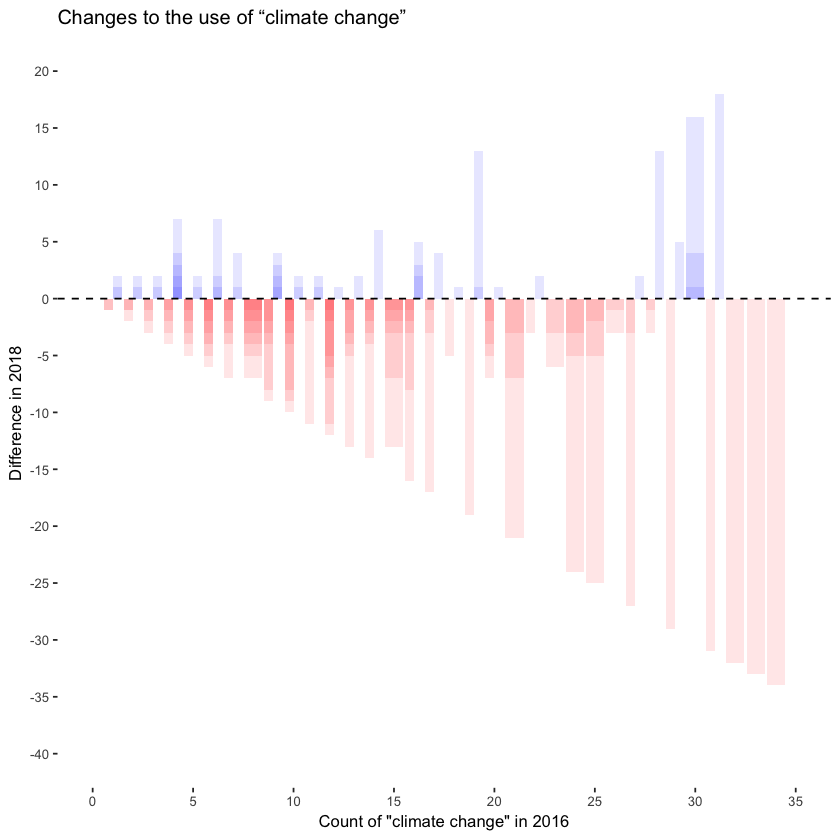

In [12]:
# This could be done in a loop to compare multiple terms, but for our purposes, we'll look at "climate change"
i=9 # "Climate Change"

df<-data.frame(first[,i], second[,i]) # Filter to only the Climate Change column, putting both Obama and Trump data in the same frame
colnames(df)<-c("obama", "trump") 
change<-which(df$obama != 0 | df$trump != 0) # REMOVE ZEROS - we don't want to plot pages that didn't change
df<-df[c(change),]

df$change <- df$trump-df$obama # Calculate a new column, the change between 2016 and 2018
# Count of unique count pairings by URLs. (1,2 | 1,4 | 3,1 | etc.) How many of each change 1->2, 1->4, 3->1 are there?
df.unique<-df %>% group_by(obama, change)%>%mutate(chg = sum(change), count=n()) 
df.unique<-unique(df.unique)

pal <- c("red", "blue") # pallette for increases and decreases

# Create the plot
p <- ggplot(df.unique, aes(obama, change, alpha=count, fill=change>0)) +
    geom_bar(stat='identity', position='dodge') +
    scale_fill_manual(values=pal) +
    labs(title = 'Changes to the use of “climate change”', x='Count of "climate change" in 2016', y='Difference in 2018')+
    theme(text=element_text(size=10), panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            plot.background=element_rect(fill='white'), panel.background = element_rect(fill='white'), 
            legend.position="none", axis.line.x = element_line(colour = "black", size=0)) +
    scale_y_continuous(limits=c(-40,20), breaks=seq(-100, 80, 5)) +
    scale_x_continuous(limits=c(0,35), breaks=seq(0, 150, 5)) + 
    geom_hline(yintercept=0, linetype="dashed", color = "black")
p

## Figure 5
Figure 5 shows pages that saw changes to both “resilience” (y-axis) and “climate change” (x-axis). Arrows indicate the directionality of change between 2016 and 2018. The top left quadrant shows pages on which “climate change” decreased and “resilience” increased; the lower left quadrant shows pages on which “climate change” decreased and “resilience” decreased. In each chart, both the x and y axes run from 0 to 22.

The first cell below prepares the data for plotting; the second actually creates the small multiples.

In [13]:
# Again, this could be done in a loop to compare multiple terms, but for our purposes, we'll look at just "climate change"
# and resilience
i=9 #"Climate Change"
j=43 #"Resilience"

col<-first[c(i,j)] # From the first timeframe, the term count
tcol<-second[c(i,j)] # From the second timframe, the term count

urlsDump<-urls # A temporary variable for our URLs
orgsDump<-data.frame(urls$org) # A temporary variable for our URLs (by agency)

# Shed zeros - We won't count pages if both terms weren't used on same page
zeros<-which(col[,1]==0 & col[,2]==0)
col<-col[-c(zeros),]
tcol<-tcol[-c(zeros),] # Here we are saying that we will eliminate second timeframe urls if in the first time the urls did not have both terms used
urlsDump<-urlsDump[-c(zeros),1]
orgsDump<-orgsDump[-c(zeros),1]

combo<-cbind(urlsDump, col, tcol, orgsDump)
colnames(combo)<-c("url", "o_CC", "o_R", "t_CC", "t_R", "orgs") 

# Now subset data to prepare for small multiples
# NOTE: BOTH TERMS HAVE TO CHANGE....i.e. no flat lines.
NE <- which(combo[,2]-combo[,4]<0 & combo[,3]-combo[,5] <0)
SE <- which(combo[,2]-combo[,4]<0 & combo[,3]-combo[,5] >0)
SW <- which(combo[,2]-combo[,4]>0 & combo[,3]-combo[,5] >0)
NW <- which(combo[,2]-combo[,4]>0 & combo[,3]-combo[,5] <0)
#E<-which(combo[,2]-combo[,4]<0 & combo[,3]-combo[,5] == 0) 
#N<-which(combo[,2]-combo[,4]==0 & combo[,3]-combo[,5] < 0) 
#S<-which(combo[,2]-combo[,4]==0 & combo[,3]-combo[,5] > 0) 

directions<-list(NE,SE,SW,NW)

In [28]:
d<-SW
combo<-cbind(urlsDump, col, tcol, orgsDump)
colnames(combo)<-c("url", "o_CC", "o_R", "t_CC", "t_R", "orgs") 

combo<-combo[c(d),] # Focus on the current direction

combo<-combo[,c(2:5)] # Get rid of unnecessary columns (URL, agency, etc.)
c<-combo %>% group_by(o_CC, o_R, t_CC, t_R) %>%mutate(count = n())
c<-unique(c)

print(c, n=40)

# A tibble: 23 x 5
# Groups:   o_CC, o_R, t_CC, t_R [23]
    o_CC   o_R  t_CC   t_R count
   <int> <int> <int> <int> <int>
 1    44     3     0     0     1
 2    27     2     0     0     1
 3    27     1     0     0     1
 4    58     6     0     0     1
 5    16     1     0     0     1
 6     4     4     0     0     1
 7    10     1     8     0     1
 8    14     4    12     1     1
 9    21    16    14    15     1
10     4     5     3     3     1
11     3     5     2     3     3
12    26    18    25    16     1
13    10     4     2     2     1
14     6     1     0     0     1
15     3     1     0     0     1
16     1     1     0     0     2
17     1     2     0     0     1
18     5     1     2     0     1
19     2     2     1     1     1
20     3    20     1    18     1
21     7     4     4     1     1
22     1     3     0     2     1
23    10     6     9     4     1


In [23]:
# Create small multiples
for (d in directions){
    
    combo<-cbind(urlsDump, col, tcol, orgsDump)
    colnames(combo)<-c("url", "o_CC", "o_R", "t_CC", "t_R", "orgs") 

    combo<-combo[c(d),] # Focus on the current direction
    
    combo<-combo[,c(2:5)] # Get rid of unnecessary columns (URL, agency, etc.)
    c<-combo %>% group_by(o_CC, o_R, t_CC, t_R) %>%mutate(count = n())
    c<-unique(c)
    
    show(c)
    
    # Draw arrows
    p<-ggplot(c,aes(x = o_CC,y = o_R))+
    geom_point(aes(x = o_CC,y = o_R), size=0, color="white") + 
    geom_point(aes(x = t_CC,y = t_R), size=0, color="white") +
    scale_y_continuous(limits=c(0,22), expand = c(0,0)) +
    scale_x_continuous(limits=c(0,22),expand = c(0,0)) + 
    labs(x="Count of climate change", y="Count of resilience")+
    theme(aspect.ratio=1)+ 
    theme(text=element_text(size=9), panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.background = element_blank(), legend.position="none", 
            axis.line = element_line(colour = "grey68", size=.1)) +
    geom_segment(aes(x = o_CC,y = o_R,xend = t_CC,yend = t_R, size=3), color="black", arrow=arrow(angle = 30, length = unit(0.12, "inches"), ends = "last", type = "open")) + 
    geom_abline(intercept=0, slope=1, colour="grey68", linetype=2, size=.2) + scale_size(range = c(.1, 1.2),guide=FALSE)  
    
    #print(p)
}

# A tibble: 20 x 5
# Groups:   o_CC, o_R, t_CC, t_R [20]
    o_CC   o_R  t_CC   t_R count
   <int> <int> <int> <int> <int>
 1     9     2    13    11     1
 2     2     0     4     3     1
 3    16    11    21    14     1
 4    10     3    12     4     1
 5     9     2    13     4     1
 6    14     0    20     1     1
 7     6     1     7     2     1
 8     7     5    11     6     1
 9     5     0     6     1     1
10     4     0     5     1     2
11    12     0    13     1     1
12    30     1    46     5     1
13    31     1    49     5     1
14    19     1    32     3     1
15     3     6     4     7     1
16    30     7    31     8     1
17    29     2    34     3     1
18     1     7     3    10     1
19    28    18    41    27     1
20    52     1    55     7     1
# A tibble: 3 x 5
# Groups:   o_CC, o_R, t_CC, t_R [3]
   o_CC   o_R  t_CC   t_R count
  <int> <int> <int> <int> <int>
1     0     1     1     0     2
2    12     4    13     1     1
3    16     3    19     2     1
# 

## Figure 6
This figure shows the average per page use of the term “climate change” for each agency in our sample, in 2016 and 2018. The trend line represents no change (x = y). The x and y axes are square root scaled.

In [ ]:
# This could be configured as a loop to go through each term but for our purposes here, we'll only look at "climate change"

i=9 # "Climate Change"

# Summarize all URLs by org (agency)
by.org<-urls%>% group_by(org) %>%summarise(num_of_pages=n()) 

# Report by agency and count
combined.url<-cbind(urls[c(1,3,6,8)], first[i], second[i], combined[i]) 
colnames(combined.url)<-c("url", "obama wm", "trump wm", "org", "before", "after","diff")

# Change by term
stats<-combined.url%>% group_by(org) %>%summarise(ObamaSum=sum(before), TrumpSum=sum(after), overall_pct_chg = 100*(sum(diff)/sum(before)), OCount=sum(before>0), TCount=sum(after>0))
stats<-merge(stats, by.org, by = "org")
stats$pagepctchg<-((stats$TCount-stats$OCount)/stats$OCount)*100

# Visualize term data by agency - changes in average use
stats.viz<-stats
stats.viz$Obamadensity<-stats.viz$ObamaSum/stats.viz$num_of_pages #rate of use across all agency pages
#stats.viz$Obamaintensity<-stats.viz$ObamaSum/stats.viz$OCount #rate of use across the pages it was used on
stats.viz$Trumpdensity<-stats.viz$TrumpSum/stats.viz$num_of_pages #rate of use across all agency pages
#stats.viz$Trumpintensity<-stats.viz$TrumpSum/stats.viz$TCount #rate of use across the pages it was used on

# For colouring the markers
stats.viz$position[stats.viz$TrumpSum- stats.viz$ObamaSum == 0] = "No Change"
stats.viz$position[stats.viz$TrumpSum- stats.viz$ObamaSum > 0] = "Increase"
stats.viz$position[stats.viz$TrumpSum- stats.viz$ObamaSum < 0] = "Decrease"

# Plot the figure
title<-("Climate Change - Average Per Page Use by Agency")
p <- ggplot(stats.viz, aes(x = Obamadensity,y = Trumpdensity, label = stats.viz$org))+
    geom_abline(intercept=0, slope=1, colour="black", size=.3, linetype="dashed") +
    geom_point(aes(x = Obamadensity,y = Trumpdensity,  color=stats.viz$position), size=4) + 
    geom_text(colour='dark grey', size = 4, box.padding = .75) + 
    scale_x_sqrt(breaks=c(0, .1,.25, .5, 1, 2, 5, 10)) +
    scale_y_sqrt(breaks=c(0, .1,.25, .5, 1,2, 5, 10)) +
    labs(x="2016", y="2018", title=title) +
    scale_colour_manual(values = c("Red", "Blue", "Grey"))

p + theme(text=element_text(size=10), panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
         plot.background=element_rect(fill='white'), panel.background = element_rect(fill='white'), 
         legend.position="none", axis.line = element_line(colour = "black", size=0))

## Figure 7
This figure shows the mean per page usage change on Cabinet vs non-cabinet agency websites, ordered left to right by our empirically driven expectations of decreases or increases in usage. Tan represents Non-Cabinet agencies; green represents Cabinet agencies. In general, Cabinet agencies removed terms more than non-Cabinet agencies. Terms like “climate change” and “climate” were especially targeted for removal, while terms like “energy independence” and “sustainability” were added. Due to our sampling method, there is very little data for the use of “unconventional oil” and “unconventional gas” and no data for non-Cabinet agencies for the term “unconventional gas”. 

In the first cell, we process the data, separating it out by agency and ultimate cabinet status for each term. In the second, we create the chart.

In [ ]:
climate_terms<-c("climate change", "climate", "greenhouse gases", "clean energy", 
                                "hydraulic fracturing", "adaptation", "air quality", "emissions", 
                                "resilience", "sustainability", "unconventional gas", "unconventional oil", 
                                "energy independence")
cabinet_final<-data.frame(Term=character(13), Average=double(13), Cabinet=character(13))
cabinet_final$Term<-climate_terms
cabinet_final$Cabinet<-c("cabinet")

nc_final<-cabinet_final
nc_final$Cabinet<-c("non-cabinet")

final<-rbind(cabinet_final, nc_final)

cabinet_agencies<-c('DOE', 'DOI', 'DOJ', 'DOT', 'EPA', 'HHS' ,'USDA', 'White House')

by.org<-urls%>% group_by(org) %>%summarise(num_of_pages=n())
by.org<-by.org[!(by.org$org == "Other"),] # Remove other agencies

for (agency in c("cabinet", "non-cabinet")){
    for (term in climate_terms){
        i<-match(term, terms)
        
        d<-cbind(urls[c(1,3,6,8)], first[i], second[i], combined[i])
        colnames(d)<-c("url", "obama wm", "trump wm", "org", "before", "after","diff")
        
        s<-d%>% group_by(org) %>%summarise(Diff = sum(after-before), ObamaSum=sum(before), TrumpSum=sum(after), OCount=sum(before >0 ), TCount=sum(after>0))
        s<-merge(s, by.org, by = "org")

        s$cabinet<- ifelse(s$org %in% cabinet_agencies, "cabinet", "non-cabinet")
        a<-s[which(s$cabinet == agency),]

        avg<-sum(a$Diff)/sum(a$OCount)
        final[(which(final$Term == term & final$Cabinet == agency)),2]<-avg  
    }
}

In [ ]:
# Order our x axis
final$Term<-factor(final$Term, levels=c("climate change", "climate", "greenhouse gases", "clean energy", 
                                "hydraulic fracturing", "adaptation", "air quality", "emissions", 
                                "resilience", "sustainability", "unconventional gas", "unconventional oil", 
                                "energy independence"))

# Create the plot
p<-ggplot(data=final, aes(x=Term, y=Average, group=Cabinet)) +
  geom_line(aes(color=Cabinet), size=2)+
  geom_point(aes(color=Cabinet), size=5) + 
  geom_abline(intercept=0, slope=0, colour="black", size=.1) +
  theme(text=element_text(size=12), 
        axis.text.x = element_text(angle = 45, hjust = 1), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(), 
        legend.position="none",
        axis.line = element_line(colour = "grey68", size=1)) +
  labs(title="Cabinet vs. Non-Cabinet Average Change Per Page", y="Change") +
  scale_color_manual(values=c('#5ab4ac','#d8b365')) +
  annotate("text", label = "Cabinet", x = 1.5, y = -3, size = 5, colour = "black")  +
  annotate("text", label = "Non-Cabinet", x = 1.75, y = .5, size = 5, colour = "black")
p

## Figure 8
The range of changes to climate-related terms in Cabinet and non-Cabinet agency websites, ordered left to right by our empirically-driven expectations of decreases or increases in usage. Tan circles represent Cabinet agency pages; green circles represent non-Cabinet agency pages. Circle size indicates the number of pages experiencing that degree of change. Cabinet agencies tended to have a larger range of term usage changes than non-Cabinet agencies, and tended to have more pages with more decreased usage for most climate-related terms. 

In the first cell, we process the data, separating it out by agency and ultimate cabinet status for each term. In the second, we create the chart.

In [ ]:
final<-data.frame(change=integer(), term=character(), cabinet=character())

for (term in climate_terms){
    i<-match(term, terms)
    
    d<-cbind(urls[c(1,8)], first[i], combined[i])
    colnames(d)<-c("url","org", "obama", "change")
    
    d<-d[which(d$obama > 0),]
    d$term<-terms[i]
    d$cabinet<- ifelse(d$org %in% cabinet_agencies, "cabinet","non-cabinet")
    
    d<-d[,-c(2, 3)]
    
    final<-rbind(final, d)
}

final<-final[order(final$change),] # Sort by amount of change
final<-final[-1,] # Remove an outlier - http://scenarios.globalchange.gov/images
final<-final[order(final$change, decreasing=TRUE), ] # Sort by amount of change
final<-final[-1,] # Remove an outlier from "Other" agency - http://ncics.org/publications/

In [ ]:
# Order our x-axis
final$term <- factor(final$term, levels=c("climate change", "climate", 
                                        "greenhouse gases", "clean energy", "hydraulic fracturing", 
                                        "adaptation", "air quality", "emissions", "resilience", "sustainability", 
                                        "unconventional gas", "unconventional oil", "energy independence"))

# How many of each change 1->2, 1->4, 3->1 are there?
f <- final %>% group_by(term, change, cabinet)%>%mutate(count=n())

p <- ggplot(f, aes(x=term, y=change)) +
  geom_point(aes(shape="20", color=cabinet, size=count), na.rm=TRUE, position=position_dodge(.5))+
  scale_size(range = c(3, 10)) +
  geom_abline(intercept=0, slope=0, colour="black", size=.1) +
  theme(text=element_text(size=14), axis.text.x = element_text(angle = 45, hjust = 1),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          legend.position="none", 
          axis.line = element_line(colour = "grey68", size=.1)) +
  labs(title="Cabinet vs. Non-Cabinet Per Page Changes", y="Change", x="Term") +
  scale_color_manual(values=c('#d8b365','#5ab4ac')) +
  annotate("text", angle = 45, hjust=1, label = "Cabinet", x = 1, y = 15, size = 3, colour = "#d8b365")  +
  annotate("text", angle = 45, hjust=1, label = "Non-Cabinet", x = 1.5, y = 30, size = 3, colour = '#5ab4ac')
p

## Figure 9
This figure shows changes in the use of key terms by page visibility. More opaque bars represent more visible pages; more transparent bars represent less visible ones. Blue indicates additions; red represents removals.

In [ ]:
# Depth analysis results were previously obtained by modifiying pages.length variable in "Process these counts"
depth <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/master/data/depthR.csv")

colnames(depth)<-c("Term", "Visibility", "Percent", "Viz")

depth <- depth[order(-depth$Percent),]

pal <- c("red", "blue")

ggplot(depth, aes(x=Visibility, y=Percent, alpha=Viz, fill = Percent>0)) + 
  geom_bar(position="dodge", stat="identity", width = .5) +
  scale_fill_manual(values = pal) +
  geom_hline(yintercept=0, size=.5, linetype="dashed") +
  ggtitle("#Differences in Use of Terms by Page Visibility") + 
  facet_wrap(~Term, ncol=3) +
  coord_flip() +
  xlab("") +  
  scale_x_discrete(breaks=NULL, labels=NULL)+
  theme(text=element_text(size=10),panel.background = element_rect(fill='white'), 
        legend.position="none", axis.text.y=element_blank(), panel.grid.major.y = element_blank(), 
        panel.grid.minor.y=element_blank(), panel.grid.minor.x=element_blank(), panel.grid.major.x=element_blank()) 

## Figure 10
This figure shows changes in the use of “climate change” by agency and page visibility. More opaque bars represent more visible pages; more transparent bars represent less visible ones. Blue indicates additions; red represents removals.

In [ ]:
# Depth analysis results were previously obtained by modifiying pages.length variable in "Process these counts"
depth.agency <- read_csv("https://raw.githubusercontent.com/edgi-govdata-archiving/web_monitoring_research/master/data/depthAgencyR.csv") 

colnames(depth.agency)<-c("Agency", "Visibility", "Percent", "Viz") 

depth.agency <- depth.agency[order(-depth.agency$Percent),]

pal <- c("red", "blue")

ggplot(depth.agency, aes(x=Visibility, y=Percent, alpha=Viz, fill = Percent>0)) + 
  geom_bar(position="dodge", stat="identity", width = .5) +
  scale_fill_manual(values = pal) +
  geom_hline(yintercept=0, size=.5, linetype="dashed") +
  ggtitle("Differences in Use of 'Climate Change' by Agency and Page Visibility") + 
  facet_wrap(~Agency, ncol=3) + 
  coord_flip() +
  xlab("") +  
  scale_x_discrete(breaks=NULL, labels=NULL)+
  theme(text=element_text(size=10),panel.background = element_rect(fill='white'), 
        legend.position="none", axis.text.y=element_blank(), panel.grid.major.y = element_blank(), 
        panel.grid.minor.y=element_blank(), panel.grid.minor.x=element_blank(), panel.grid.major.x=element_blank()) 